In [1]:
import tensorflow as tf

In [2]:
import pandas as pd
import os
import numpy as np
from keras_preprocessing import image as im
tf.random.set_seed(
    5
)

# Loading data

In [3]:
def load_data(image_path, annotations_path):
    df = pd.read_csv(annotations_path)
    df = df[~df['human_sentiment'].isna()]
    in_folder = os.listdir(image_path)
    df.loc[df['image_name'].isin(in_folder), 'image_name'] = \
    df.loc[df['image_name'].isin(in_folder), 'image_name'].apply(lambda x: os.path.join(image_path,x))
    images = []
    for image_name in df['image_name'].values:
        images.append(np.array(im.load_img(image_name, target_size=(224,224))))
    images = np.array(images)
    images = images/255
    annotations = df['annotation'].str.lower().values
    return images, annotations

In [4]:
images, annotations = load_data("../../../images/", '../../../emo-at-cap.csv')

# Processing of data

In [5]:
import nltk

In [6]:
tokenizer = nltk.tokenize.WordPunctTokenizer()

In [7]:
tokenized = [tokenizer.tokenize(i) for i in annotations]

In [8]:
unique_tokens, unique_counts = np.unique(np.hstack(tokenized), return_counts=True)

In [9]:
sorted(list(zip(unique_tokens, unique_counts)), key = lambda x: x[1])[::-1][:50]

[('the', 3261),
 ('is', 2031),
 ('man', 1905),
 ('and', 1536),
 ('woman', 1361),
 ('are', 1036),
 ('a', 963),
 ('to', 891),
 ('looks', 751),
 ('happy', 705),
 ('with', 547),
 ('something', 480),
 ('men', 478),
 ('of', 463),
 ('two', 408),
 ('other', 361),
 ('people', 343),
 ('couple', 334),
 (',', 330),
 ('in', 278),
 ('look', 270),
 ('because', 265),
 ('they', 256),
 ('about', 247),
 ('on', 246),
 ('at', 192),
 ('trying', 190),
 ('serious', 189),
 ('women', 184),
 ('each', 179),
 ('together', 176),
 ('by', 175),
 ('having', 171),
 ('flirting', 165),
 ('he', 155),
 ('smiling', 151),
 ('arguing', 141),
 ('angry', 140),
 ('scared', 138),
 ('worried', 137),
 ('hugging', 135),
 ('surprised', 134),
 ('calm', 133),
 ('company', 131),
 ('her', 129),
 ('group', 123),
 ('for', 121),
 ('she', 117),
 ('looking', 117),
 ('his', 115)]

In [10]:
len(unique_tokens)

2162

In [11]:
pad_token = '<PAD>'
start_token = '<S>'
end_token = '<E>'

In [12]:
vocab = dict(zip(unique_tokens,list(range(3,len(unique_tokens)+3))))
vocab[pad_token] = 0
vocab[start_token] = 1
vocab[end_token] = 2

In [13]:
inverse_vocab = dict([(v,k) for k,v in vocab.items()])

In [14]:
add_special_tokens = lambda x: [start_token] + x + [end_token]

In [15]:
tokenized = list(map(add_special_tokens,tokenized))

In [16]:
max_len = len(max(tokenized, key=len))

In [17]:
indexed = list(map(lambda x: [vocab[i] for i in x],tokenized))

In [18]:
padded = tf.keras.preprocessing.sequence.pad_sequences(indexed, truncating='post')

In [19]:
images.shape

(3840, 224, 224, 3)

# Model with transfer learning

In [20]:
def calc_size(x, f, s, padding='same'):
    p = 2 if padding=='same' else 1
    return (x-f+2)/s+1

### Convolutional model

In [92]:
import tensorflow.keras.applications as apps


In [93]:
class ConvEncoder(tf.keras.Model):
    def __init__(self):
        super(ConvEncoder, self).__init__()
        #building resnet
        resnet = apps.ResNet152V2(include_top=False, weights='imagenet')
        outputs = [i for i in resnet.layers if i.name=='conv4_block5_out'][0]
        inputs = resnet.layers[0]
        self.resnet_extractor = tf.keras.models.Model(inputs=inputs.input, outputs=outputs.output)
        self.resnet_extractor.trainable = False
        
        #batch norm
        self.batch_norm1 =  tf.keras.layers.BatchNormalization()
        self.batch_norm2 =  tf.keras.layers.BatchNormalization()
        self.batch_norm3 =  tf.keras.layers.BatchNormalization()

        
        #on top extractors 
        self.conv1 = tf.keras.layers.Conv2D(filters=512, kernel_size=7, activation='relu',
                               padding='same', name='conv1', strides=(2,2))
        self.conv2 = tf.keras.layers.Conv2D(filters=256, kernel_size=5, activation='relu',
                                       padding='same', name='conv2', strides=(2,2))
        self.conv3 = tf.keras.layers.Conv2D(filters=256, kernel_size=4, activation='relu',
                                       padding='same', name='conv3', strides=(2,2))
        self.conv4 = tf.keras.layers.Conv2D(filters=256, kernel_size=1, activation='relu',
                                       padding='same', name='conv4', strides=(2,2))
        
        self.conv5 = tf.keras.layers.Conv2D(filters=256, kernel_size=1, activation='relu',
                                       padding='same', name='conv5', strides=(2,2))
        self.flatten = tf.keras.layers.Flatten()
        
    def call(self, input):
        resnet_features = self.resnet_extractor(input)
        conv1_out = self.batch_norm1(self.conv1(resnet_features))
        conv2_out = self.batch_norm2(self.conv2(conv1_out))
        conv3_out = self.batch_norm3(self.conv3(conv2_out))
        conv4_out = self.conv4(conv3_out)
        conv5_out = self.conv5(conv3_out)
        return [self.flatten(conv4_out), self.flatten(conv5_out)]

In [94]:
conv_encoder = ConvEncoder()

In [95]:
conv_res = conv_encoder(np.expand_dims(images[0],axis=0))


If you intended to run this layer in float32, you can safely ignore this warning. If in doubt, this warning is likely only an issue if you are porting a TensorFlow 1.X model to TensorFlow 2.

To change all layers to have dtype float64 by default, call `tf.keras.backend.set_floatx('float64')`. To change just this layer, pass dtype='float64' to the layer constructor. If you are the author of this layer, you can disable autocasting by passing autocast=False to the base Layer constructor.



In [96]:
conv_res

[<tf.Tensor: shape=(1, 256), dtype=float32, numpy=
 array([[0.18044674, 0.        , 0.        , 0.        , 0.17836721,
         0.07201549, 0.        , 0.07633087, 0.08137889, 0.        ,
         0.        , 0.06016247, 0.0271579 , 0.01130108, 0.        ,
         0.05635251, 0.11776319, 0.2944244 , 0.        , 0.        ,
         0.21907699, 0.16431975, 0.21890369, 0.        , 0.2201566 ,
         0.17337525, 0.        , 0.        , 0.        , 0.29836762,
         0.05729098, 0.        , 0.08942068, 0.        , 0.10094642,
         0.        , 0.        , 0.        , 0.        , 0.03347997,
         0.        , 0.0825975 , 0.        , 0.16253117, 0.37322557,
         0.        , 0.        , 0.14317966, 0.        , 0.        ,
         0.22419856, 0.11687281, 0.04424128, 0.10621466, 0.03909818,
         0.11569512, 0.1303684 , 0.        , 0.        , 0.        ,
         0.10384209, 0.        , 0.        , 0.        , 0.09321293,
         0.        , 0.01423153, 0.02838157, 0.05860

### LSTM model

### making w2v embeddings

In [26]:
!pip install gensim

In [33]:
import gensim.downloader as api

In [35]:
w2v_embeddings = api.load('word2vec-google-news-300')

[================================================--] 97.6% 1622.5/1662.8MB downloaded

In [45]:
def build_embeddings(vocab, word_vectors, embed_dim):
    emb_matrix = np.zeros(shape=(len(vocab)+ 1 , embed_dim), dtype='float32')
    count = 0
    for word, i in vocab.items():
        try:
            emb_matrix[i, :] = word_vectors.get_vector(word)
        except:
            count += 1
            emb_matrix[i, :] = np.random.uniform(-0.1, 0.1, embed_dim)
    print('glove embedding out of vocabulary：', count)
    return emb_matrix


In [46]:
w2v_embeddings = build_embeddings(vocab, w2v_embeddings, 300)

glove embedding out of vocabulary： 22


### building model

In [105]:
class LSTMDecoder(tf.keras.Model):
    def __init__(self, max_tokens, lstm_units, embeddings=None, dim=128):
        super(LSTMDecoder, self).__init__()
        self.embeddings = tf.keras.layers.Embedding(input_dim=max_tokens+1, output_dim=dim, name='embeddings',
                                                   weights=[embeddings])
        self.dropout = tf.keras.layers.SpatialDropout1D(0.1)
        self.layer_norm = tf.keras.layers.LayerNormalization(epsilon=1e-6, name='layer_normalization')
        self.lstm = tf.keras.layers.LSTM(units=lstm_units, return_state=True, name='lstm_decoder')
        self.output_dense = tf.keras.layers.Dense(units=max_tokens)
        
    def call(self, input, features):
        embedded = self.dropout(self.embeddings(input))
        result_lstm, state_h, state_c = self.lstm(embedded, initial_state=features)
        normalized = self.layer_norm(result_lstm)
        logits = self.output_dense(normalized)
        return logits, [state_h, state_c]

In [106]:
lstm_decoder = LSTMDecoder(len(inverse_vocab), conv_res[0].shape[1], w2v_embeddings, dim=300)

In [107]:
lstm_decoder(np.expand_dims(padded[0],axis=0), conv_res)

(<tf.Tensor: shape=(1, 2165), dtype=float32, numpy=
 array([[-0.20875634, -0.12613702,  0.5828515 , ..., -0.26522648,
         -0.3224231 ,  0.620824  ]], dtype=float32)>,
 [<tf.Tensor: shape=(1, 256), dtype=float32, numpy=
  array([[ 2.99951178e-03, -1.77181140e-02, -2.55098231e-02,
           2.17046421e-02,  3.97079550e-02,  6.50589243e-02,
          -2.37859394e-02, -6.65025378e-04,  4.43915464e-03,
          -6.23601377e-02, -2.38624867e-02,  4.40784320e-02,
           2.67916918e-02, -6.37600869e-02,  9.63066064e-04,
          -2.41358951e-02, -5.66397086e-02, -1.51813952e-02,
          -3.27920131e-02,  1.40118478e-02, -9.64830630e-03,
           6.89840168e-02, -4.33490388e-02,  4.21012938e-02,
           1.96354985e-02, -1.20948283e-02, -2.90787648e-02,
           7.94745702e-03, -4.35594171e-02, -1.33421095e-02,
           2.75331400e-02, -1.40970154e-02,  2.23335903e-02,
           4.46693338e-02,  1.51427286e-02, -4.59675677e-02,
           2.72657839e-03,  4.03401516e-02, 

### Training

In [108]:
from sklearn.model_selection import train_test_split

In [109]:
loss_object = tf.keras.losses.SparseCategoricalCrossentropy(reduction='none',
                                                                         from_logits=True)
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-4)


In [110]:
def loss_function(real, pred):
        mask = tf.math.logical_not(tf.math.equal(real, vocab[pad_token]))
        loss_ = loss_object(real, pred)

        mask = tf.cast(mask, dtype=loss_.dtype)
        loss_ *= mask
        return loss_

In [111]:
@tf.function
def train_step(image, target, lengths, optimizer):

    with tf.GradientTape() as tape:
        initial_state = conv_encoder(image)
        # Teacher forcing - feeding the target as the next input
        batched_loss = []
        for t in range(1, target.shape[1]):
            
            dec_input = tf.expand_dims(target[:, t-1], 1)
            result, initial_state = lstm_decoder(input=dec_input, features=initial_state)

            batched_loss.append(loss_function(target[:, t], result))
        batched_loss = tf.reshape(tf.stack(batched_loss), shape=target[:,1:].shape)
        batched_loss = tf.reduce_sum(batched_loss, axis=1)
        lengths = tf.cast(lengths, dtype=batched_loss.dtype)
        loss = tf.reduce_mean(batched_loss / lengths)

    perplexity = tf.exp(loss)

    variables = conv_encoder.trainable_variables + lstm_decoder.trainable_variables
    gradients = tape.gradient(loss, variables)

    optimizer.apply_gradients(zip(gradients, variables))

    return loss, perplexity

In [112]:
@tf.function
def evaluate(image, target, lengths, optimizer):

    initial_state = conv_encoder(image)
    # Teacher forcing - feeding the target as the next input
    batched_loss = []
    for t in range(1, target.shape[1]):

        dec_input = tf.expand_dims(target[:, t-1], 1)
        result, initial_state = lstm_decoder(input=dec_input, features=initial_state)

        batched_loss.append(loss_function(target[:, t], result))

    batched_loss = tf.reshape(tf.stack(batched_loss), shape=target[:,1:].shape)
    batched_loss = tf.reduce_sum(batched_loss, axis=1)
    lengths = tf.cast(lengths, dtype=batched_loss.dtype)
    loss = tf.reduce_mean(batched_loss / lengths)

    perplexity = tf.exp(loss)


    return loss, perplexity

In [113]:
train_images, test_images, train_sequences, test_sequences =  train_test_split(images, padded, test_size=0.1, random_state=9)

In [114]:
train_length = (train_sequences!=vocab[pad_token]).sum(axis=1)-2

In [115]:
test_length = (test_sequences!=vocab[pad_token]).sum(axis=1)-2

In [116]:
epochs = 30
batch_size= 64
train_images = np.array(np.array_split(train_images, len(train_images)//batch_size))
test_images = np.array(np.array_split(test_images, len(test_images)//batch_size))
train_sequences = np.array(np.array_split(train_sequences, len(train_sequences)//batch_size))
test_sequences = np.array(np.array_split(test_sequences, len(test_sequences)//batch_size))
train_length = np.array(np.array_split(train_length, len(train_length)//batch_size))
test_length = np.array(np.array_split(test_length, len(test_length)//batch_size))

In [117]:
train_images.shape, train_sequences.shape, train_length.shape

((54, 64, 224, 224, 3), (54, 64, 37), (54, 64))

In [118]:
!pip install tqdm

In [119]:
from tqdm import tqdm

In [120]:
train_loss = []
train_perplexity = []
test_loss = []
test_perplexity = []
for epoch in range(epochs):
    epoch_train_loss = 0
    epoch_train_perplexity = 0
    epoch_test_loss = 0
    epoch_test_perplexity = 0
    for batch_train_images, batch_train_sequences, batched_train_length in tqdm(zip(train_images,train_sequences,train_length)):
        batched_train_loss, batched_train_perplexity = train_step(batch_train_images,batch_train_sequences,batched_train_length, optimizer)
        epoch_train_loss+=batched_train_loss
        epoch_train_perplexity+=batched_train_perplexity
    epoch_train_loss = epoch_train_loss/batch_size
    epoch_train_perplexity =epoch_train_perplexity/batch_size
    train_loss.append(epoch_train_loss)
    train_perplexity.append(epoch_train_perplexity)
    print('Finished epoch {}; Train loss : {}; Train perplexity : {}'.format(epoch,epoch_train_loss,epoch_train_perplexity))
    for batch_test_images, batch_test_sequences, batched_test_length in zip(test_images,test_sequences,test_length):
        batched_test_loss, batched_test_perplexity = evaluate(batch_test_images,batch_test_sequences,batched_test_length, optimizer)
        epoch_test_loss+=batched_test_loss
        epoch_test_perplexity+=batched_test_perplexity
    epoch_test_loss = epoch_test_loss/batch_size
    epoch_test_perplexity =epoch_test_perplexity/batch_size
    test_perplexity.append(epoch_test_perplexity)
    test_loss.append(epoch_test_loss)
    print('Test loss : {}; Test perplexity : {}'.format(epoch_test_loss,epoch_test_perplexity))


54it [01:43,  1.91s/it]


Finished epoch 0; Train loss : 7.309874057769775; Train perplexity : 10257.3720703125


0it [00:00, ?it/s]

Test loss : 0.6760071516036987; Test perplexity : 140.18861389160156


54it [00:48,  1.11it/s]


Finished epoch 1; Train loss : 5.524888038635254; Train perplexity : 701.1524658203125


0it [00:00, ?it/s]

Test loss : 0.5589247941970825; Test perplexity : 39.397220611572266


54it [00:48,  1.11it/s]


Finished epoch 2; Train loss : 4.784228801727295; Train perplexity : 269.6246643066406


0it [00:00, ?it/s]

Test loss : 0.5036327242851257; Test perplexity : 21.692401885986328


54it [00:48,  1.10it/s]


Finished epoch 3; Train loss : 4.367570877075195; Train perplexity : 162.0404510498047


0it [00:00, ?it/s]

Test loss : 0.46781420707702637; Test perplexity : 14.73385238647461


54it [00:48,  1.11it/s]


Finished epoch 4; Train loss : 4.064328670501709; Train perplexity : 112.39606475830078


0it [00:00, ?it/s]

Test loss : 0.4417506158351898; Test perplexity : 11.114362716674805


54it [00:48,  1.11it/s]


Finished epoch 5; Train loss : 3.8222978115081787; Train perplexity : 83.98272705078125


0it [00:00, ?it/s]

Test loss : 0.4199855327606201; Test perplexity : 8.778703689575195


54it [00:48,  1.11it/s]


Finished epoch 6; Train loss : 3.622882843017578; Train perplexity : 66.03278350830078


0it [00:00, ?it/s]

Test loss : 0.4026850163936615; Test perplexity : 7.279776573181152


54it [00:48,  1.11it/s]


Finished epoch 7; Train loss : 3.4535317420959473; Train perplexity : 53.770362854003906


0it [00:00, ?it/s]

Test loss : 0.38891151547431946; Test perplexity : 6.273582935333252


54it [00:48,  1.11it/s]


Finished epoch 8; Train loss : 3.3086936473846436; Train perplexity : 45.0804557800293


0it [00:00, ?it/s]

Test loss : 0.37810295820236206; Test perplexity : 5.584174156188965


54it [00:49,  1.09it/s]


Finished epoch 9; Train loss : 3.1814146041870117; Train perplexity : 38.61697769165039


0it [00:00, ?it/s]

Test loss : 0.3690558075904846; Test perplexity : 5.064923286437988


54it [00:48,  1.10it/s]


Finished epoch 10; Train loss : 3.0652220249176025; Train perplexity : 33.512351989746094


0it [00:00, ?it/s]

Test loss : 0.3657762110233307; Test perplexity : 4.883938789367676


54it [00:49,  1.10it/s]


Finished epoch 11; Train loss : 2.9882876873016357; Train perplexity : 30.536861419677734


0it [00:00, ?it/s]

Test loss : 0.3564532995223999; Test perplexity : 4.415975093841553


54it [00:48,  1.11it/s]


Finished epoch 12; Train loss : 2.8944644927978516; Train perplexity : 27.233449935913086


0it [00:00, ?it/s]

Test loss : 0.35203272104263306; Test perplexity : 4.21450138092041


54it [00:49,  1.09it/s]


Finished epoch 13; Train loss : 2.80708384513855; Train perplexity : 24.46759605407715


0it [00:00, ?it/s]

Test loss : 0.3489188849925995; Test perplexity : 4.0754194259643555


54it [00:48,  1.11it/s]


Finished epoch 14; Train loss : 2.7384588718414307; Train perplexity : 22.533815383911133


0it [00:00, ?it/s]

Test loss : 0.34604278206825256; Test perplexity : 3.94573974609375


54it [00:49,  1.10it/s]


Finished epoch 15; Train loss : 2.6827759742736816; Train perplexity : 21.002517700195312


0it [00:00, ?it/s]

Test loss : 0.34435540437698364; Test perplexity : 3.8821070194244385


54it [00:50,  1.08it/s]


Finished epoch 16; Train loss : 2.6478822231292725; Train perplexity : 20.1877498626709


0it [00:00, ?it/s]

Test loss : 0.34048599004745483; Test perplexity : 3.7194902896881104


54it [00:49,  1.09it/s]


Finished epoch 17; Train loss : 2.5875484943389893; Train perplexity : 18.75516700744629


0it [00:00, ?it/s]

Test loss : 0.33844107389450073; Test perplexity : 3.636171579360962


54it [00:48,  1.11it/s]


Finished epoch 18; Train loss : 2.540431261062622; Train perplexity : 17.680221557617188


0it [00:00, ?it/s]

Test loss : 0.3388529121875763; Test perplexity : 3.6520047187805176


54it [00:48,  1.11it/s]


Finished epoch 19; Train loss : 2.490946054458618; Train perplexity : 16.64523696899414


0it [00:00, ?it/s]

Test loss : 0.33705466985702515; Test perplexity : 3.5806756019592285


54it [00:48,  1.11it/s]


Finished epoch 20; Train loss : 2.4296844005584717; Train perplexity : 15.44651985168457


0it [00:00, ?it/s]

Test loss : 0.3364376723766327; Test perplexity : 3.5504400730133057


54it [00:49,  1.10it/s]


Finished epoch 21; Train loss : 2.3807425498962402; Train perplexity : 14.552839279174805


0it [00:00, ?it/s]

Test loss : 0.3370898365974426; Test perplexity : 3.5750160217285156


54it [00:48,  1.11it/s]


Finished epoch 22; Train loss : 2.326982021331787; Train perplexity : 13.639692306518555


0it [00:00, ?it/s]

Test loss : 0.33584851026535034; Test perplexity : 3.5320229530334473


54it [00:48,  1.11it/s]


Finished epoch 23; Train loss : 2.2926230430603027; Train perplexity : 13.100852012634277


0it [00:00, ?it/s]

Test loss : 0.3369288146495819; Test perplexity : 3.5796329975128174


54it [00:48,  1.11it/s]


Finished epoch 24; Train loss : 2.2792563438415527; Train perplexity : 12.891822814941406


0it [00:00, ?it/s]

Test loss : 0.33936405181884766; Test perplexity : 3.661496639251709


54it [00:48,  1.11it/s]


Finished epoch 25; Train loss : 2.2480545043945312; Train perplexity : 12.394377708435059


0it [00:00, ?it/s]

Test loss : 0.3326718509197235; Test perplexity : 3.4154105186462402


54it [00:48,  1.11it/s]


Finished epoch 26; Train loss : 2.176668405532837; Train perplexity : 11.375617027282715


0it [00:00, ?it/s]

Test loss : 0.33388590812683105; Test perplexity : 3.4582998752593994


54it [00:48,  1.11it/s]


Finished epoch 27; Train loss : 2.1115365028381348; Train perplexity : 10.515596389770508


0it [00:00, ?it/s]

Test loss : 0.33690351247787476; Test perplexity : 3.5736331939697266


54it [00:48,  1.10it/s]


Finished epoch 28; Train loss : 2.0560991764068604; Train perplexity : 9.830327033996582


0it [00:00, ?it/s]

Test loss : 0.3398571312427521; Test perplexity : 3.690608501434326


54it [00:48,  1.11it/s]


Finished epoch 29; Train loss : 2.0081253051757812; Train perplexity : 9.277995109558105
Test loss : 0.34259694814682007; Test perplexity : 3.81363582611084


# Viewing and saving results

In [121]:
df = pd.DataFrame()
model_name = 'conv_lstm_transfer_learning'
df['train_perplexity_{}'.format(model_name)] = train_perplexity
df['test_perplexity_{}'.format(model_name)] = test_perplexity
df['train_loss_{}'.format(model_name)] = train_loss
df['test_loss_{}'.format(model_name)] = test_loss
df.to_csv('{}_logs.csv'.format(model_name),index=False)

In [122]:
import matplotlib.pyplot as plt
import seaborn as sns
sns.set()

Text(0, 0.5, 'Perplexity')

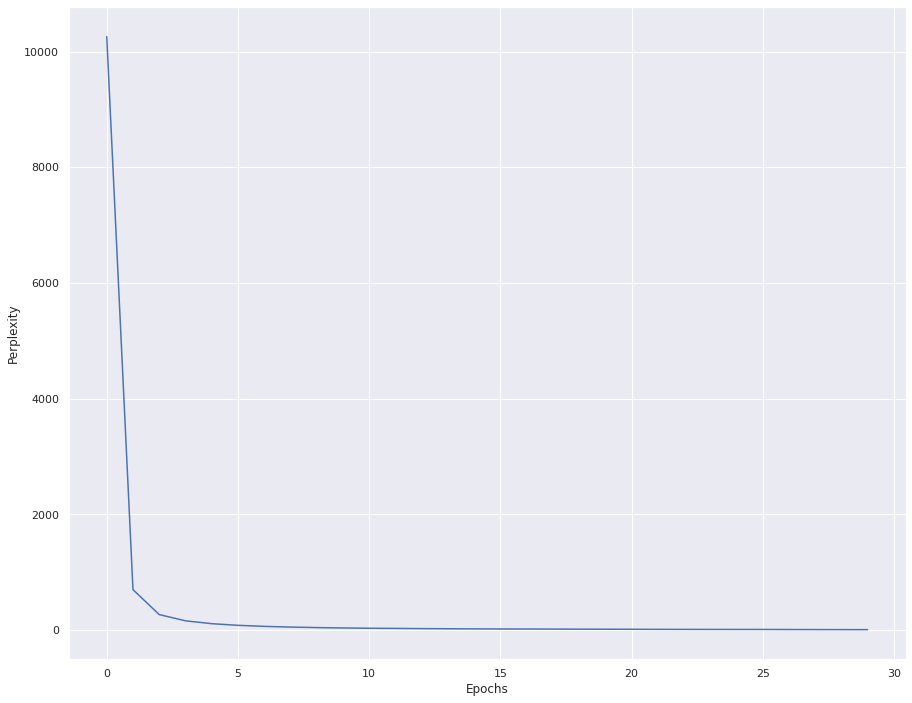

In [123]:
plt.figure(figsize=(15,12))
plt.plot(df['train_perplexity_{}'.format(model_name)])
plt.xlabel('Epochs')
plt.ylabel('Perplexity')

Text(0, 0.5, 'Perplexity')

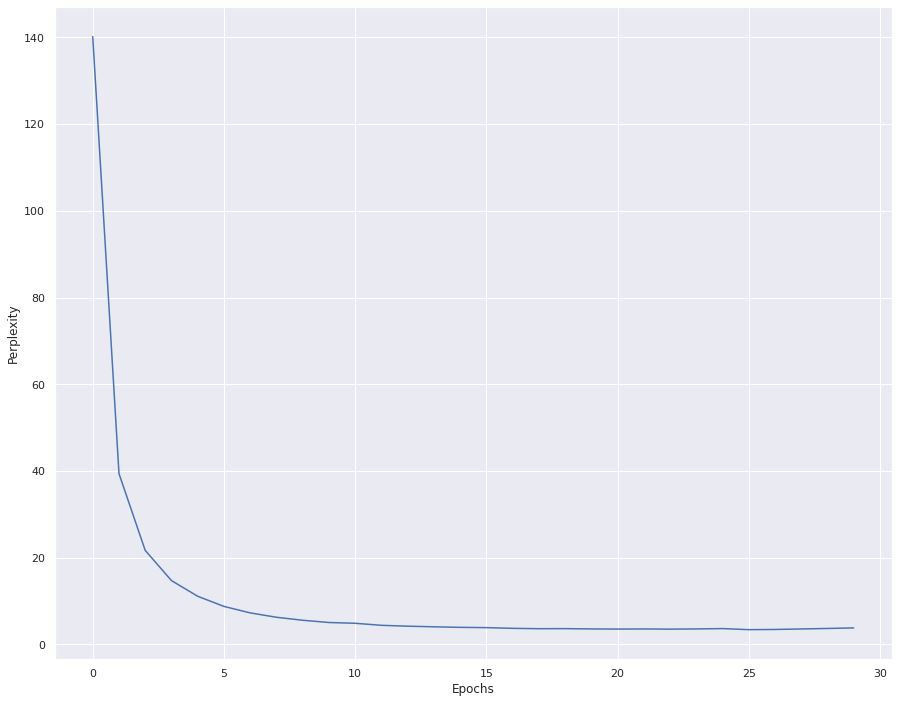

In [124]:
plt.figure(figsize=(15,12))
plt.plot(df['test_perplexity_{}'.format(model_name)])
plt.xlabel('Epochs')
plt.ylabel('Perplexity')

In [125]:
np.arange(0,max(df['train_loss_{}'.format(model_name)]),0.5)

array([0. , 0.5, 1. , 1.5, 2. , 2.5, 3. , 3.5, 4. , 4.5, 5. , 5.5, 6. ,
       6.5, 7. ])

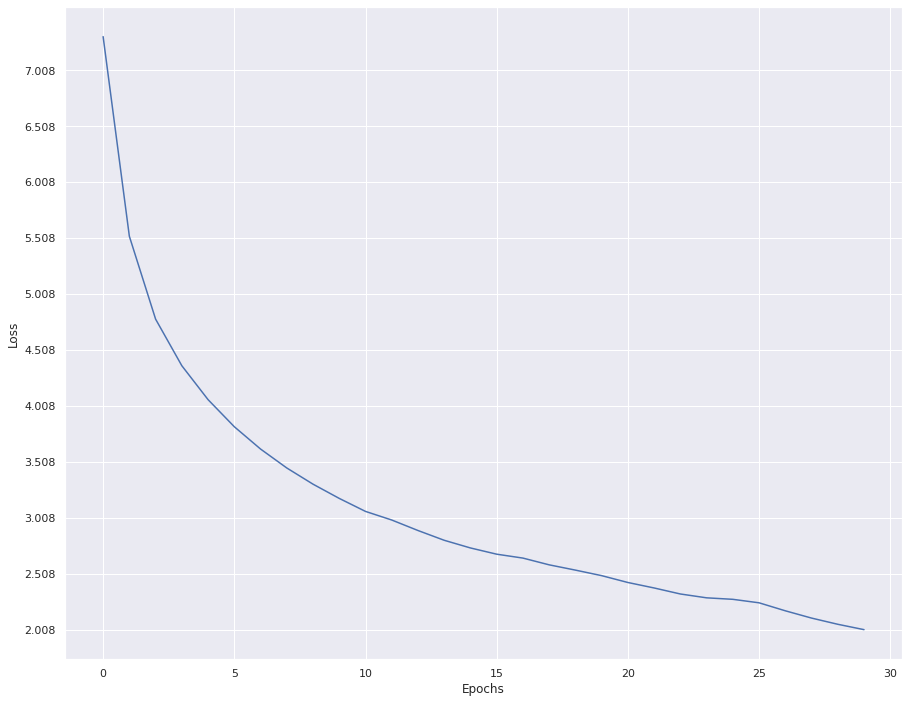

In [126]:
plt.figure(figsize=(15,12))
plt.plot(df['train_loss_{}'.format(model_name)])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.yticks(np.arange(min(df['train_loss_{}'.format(model_name)]),max(df['train_loss_{}'.format(model_name)]),0.5));

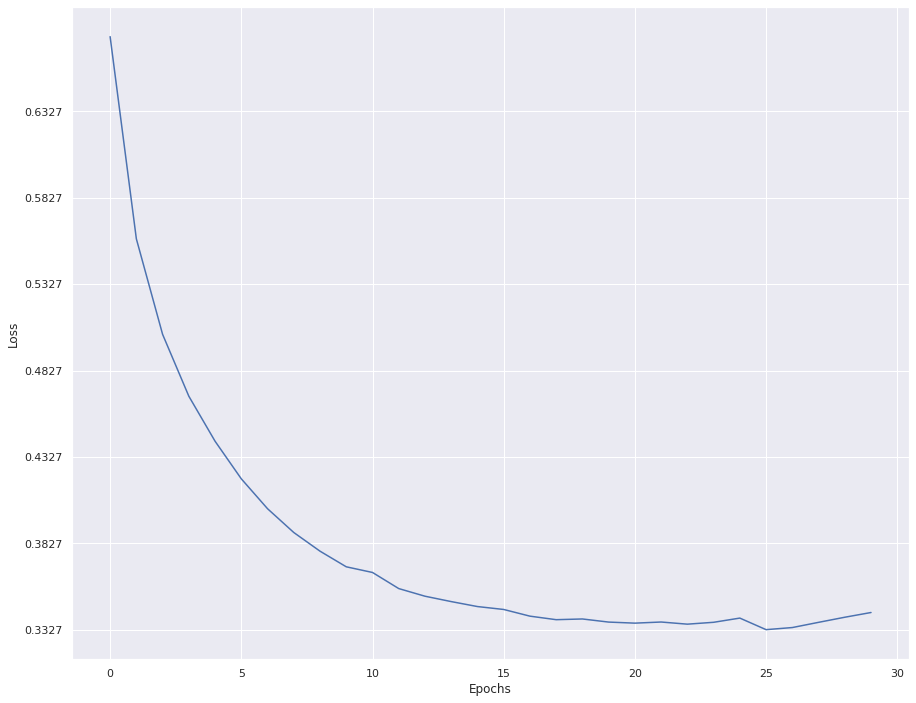

In [127]:
plt.figure(figsize=(15,12))
plt.plot(df['test_loss_{}'.format(model_name)])
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.yticks(np.arange(min(df['test_loss_{}'.format(model_name)]),max(df['test_loss_{}'.format(model_name)]),0.05));

# Testing model

In [128]:
import matplotlib.pyplot as plt
import seaborn as sns

In [129]:
class Decoder:
    def __init__(self, encoder: tf.keras.Model,
                 decoder: tf.keras.Model,
                 start_token: int,
                 end_token: int,
                 max_len: int = 10, ):
        self.encoder = encoder
        self.decoder = decoder
        self.max_len = max_len
        self.start_token = start_token
        self.end_token = end_token

    def decode(self, input):
        pass


class GreedyDecoder(Decoder):
    def __init__(self, encoder: tf.keras.Model,
                 decoder: tf.keras.Model,
                 start_token: int,
                 end_token: int,
                 max_len: int = 10,
                 ):
        super().__init__(encoder,
                         decoder,
                         start_token,
                         end_token,
                         max_len
                         )

    def decode(self, input, max_len_output=50):
        initial_state = self.encoder(np.expand_dims(input, axis=0))

        target_seq = np.zeros((1, 1))
        target_seq[0, 0] = self.start_token

        res = []
        while True:
            # Sample a token
            output, initial_state = self.decoder(target_seq,initial_state)
            sampled_token_index = np.argmax(output)

            if len(res) > max_len_output or sampled_token_index == self.end_token:
                break

            res.append(sampled_token_index)

            target_seq = np.zeros((1, 1))
            target_seq[0, 0] = sampled_token_index

       
        return res


In [130]:
class BeamSearchDecoder(Decoder):
    def __init__(self, encoder: tf.keras.Model,
                 decoder: tf.keras.Model,
                 start_token: int,
                 end_token: int,
                 max_len: int = 10,
                 ):
        super().__init__(encoder,
                         decoder,
                         start_token,
                         end_token,
                         max_len
                         )

    def decode(self, input, beam_size=3):
        start = [self.start_token]
        initial_state = self.encoder(np.expand_dims(input,axis=0))


        start_word = [[start, 0.0, initial_state]]

        while len(start_word[0][0]) < self.max_len:
            temp = []
            for s in start_word:
                target_seq = np.array([[s[0][-1]]])
                initial_state = s[-1]
                output, initial_state= self.decoder(target_seq, initial_state)
                output = np.hstack(output)
                output = tf.nn.softmax(output).numpy()
                word_preds = np.argsort(output)[-beam_size:]

                for w in word_preds:
                    next_cap, prob = s[0][:], s[1]
                    next_cap.append(w)
                    prob += output[w]
                    temp.append([next_cap, prob, initial_state])

            start_word = temp
            # Sorting according to the probabilities
            start_word = sorted(start_word, reverse=False, key=lambda l: l[1])
            # Getting the top words
            start_word = start_word[-beam_size:]

        start_word = start_word[-1][0]

        final_caption = []

        for i in start_word:
            if i != self.end_token:
                final_caption.append(i)
            else:
                break
        return final_caption[1:]

In [131]:
def predict(data, decoder, inverse_vocab,
           beam_size=None):
    if beam_size:
        result = decoder.decode(data, beam_size=beam_size)
    else:
        result = decoder.decode(data)
    return ' '.join([inverse_vocab[i] for i in result])

In [132]:
greedy_decoder = GreedyDecoder(conv_encoder, lstm_decoder, vocab[start_token], vocab[end_token],
             max_len=39)

In [133]:
beam_decoder = BeamSearchDecoder(conv_encoder, lstm_decoder, vocab[start_token], vocab[end_token],
             max_len=39)

In [134]:
images.shape

(3840, 224, 224, 3)

In [148]:
sample = np.random.choice(range(len(images)))
sample = images[sample]

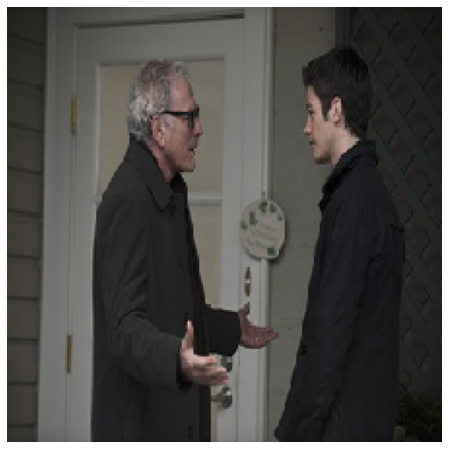

In [149]:
plt.figure(figsize=(8,8))
plt.imshow(sample)
plt.grid([])
plt.axis('off');

In [150]:
predict(sample, greedy_decoder, inverse_vocab)

'people man looks a man looks a a man looks and a family looks happy and a because they have a good because they are going to have a good time in the bed'

In [151]:
predict(sample, beam_decoder, inverse_vocab, beam_size=5)

"people people looks a man looks a a man and a couple looks despaired and aggressive , because they don ' t ' t pay attention to what he is trying to shoot somebody"

# Blue score calculation

In [152]:
from nltk.translate.bleu_score import sentence_bleu


### making predictions on test dataset with beam_size of 5

In [153]:
test_predictions = []
for batch in tqdm(test_images):
    for image in batch:
        result = predict(image, beam_decoder, inverse_vocab, beam_size=5)
        test_predictions.append(result)

100%|██████████| 6/6 [07:42<00:00, 77.06s/it]


In [154]:
test_predictions = [i.split(' ') for i in test_predictions]

In [155]:
reshaped_sequences = test_sequences.reshape(test_sequences.shape[0]*test_sequences.shape[1],-1)

In [156]:
test_sentences = []
for i in reshaped_sequences:
    tmp = []
    for word in i:
        if word!=0 and word!=1 and word!=2:
            tmp.append(inverse_vocab[word])
    test_sentences.append(tmp)

In [157]:
bleu_score = []
for reference, prediction in zip(test_sentences, test_predictions):
    bleu_score.append(sentence_bleu(reference, prediction))
print('Bleu score on test data : {}'.format(np.mean(bleu_score)))

/home/ec2-user/anaconda3/envs/amazonei_tensorflow2_p36/lib/python3.6/site-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/ec2-user/anaconda3/envs/amazonei_tensorflow2_p36/lib/python3.6/site-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/ec2-user/anaconda3/envs/amazonei_tensorflow2_p36/lib/python3.6/site-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
ho

Bleu score on test data : 7.638488665736888e-232


### making predictions on test dataset with beam_size of 10

In [158]:
test_predictions = []
for batch in tqdm(test_images):
    for image in batch:
        result = predict(image, beam_decoder, inverse_vocab, beam_size=10)
        test_predictions.append(result)

100%|██████████| 6/6 [14:59<00:00, 149.85s/it]


In [159]:
test_predictions = [i.split(' ') for i in test_predictions]

In [160]:
bleu_score = []
for reference, prediction in zip(test_sentences, test_predictions):
    bleu_score.append(sentence_bleu(reference, prediction))
print('Bleu score on test data : {}'.format(np.mean(bleu_score)))

Bleu score on test data : 7.531845725477715e-232
